In [2]:
"""Anomaly Detection Example"""
from __future__ import print_function
from IPython.display import display, HTML

from matplotlib import pyplot as plt
%matplotlib inline
import os
import sys
import argparse
import math
from collections import Counter
import ipaddress
import seaborn as sns
# Third Party Imports
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.externals import joblib
# Local imports
from zat import log_to_dataframe
from zat import dataframe_to_matrix
from sklearn.externals import joblib


C:\Users\atti-001\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 'IESCO' data is loaded
##### total length of data is 390734 rows

In [3]:
pd.set_option('display.width', 1000)
bro_log = 'http'
bro_df = joblib.load('../../../IESCO_complete_dec_may/http pickle/http.pkl')

In [14]:
bro_df.reset_index(inplace=True)[['ts','id.orig_h','id.resp_h','host']].to_json()

TypeError: 'NoneType' object is not subscriptable

In [16]:
bro_df.head(2).reset_index()[['ts','id.orig_h','id.resp_h','host']].to_json()

'{"ts":{"0":1585684800549,"1":1585684802013},"id.orig_h":{"0":"39.32.14.105","1":"175.107.11.143"},"id.resp_h":{"0":"172.16.2.211","1":"172.16.2.211"},"host":{"0":"210.2.172.19","1":"210.2.172.19"}}'

In [9]:
bro_df = bro_df[['ts','id.orig_h','id.resp_h','id.orig_p','id.resp_p', 'method', 'resp_mime_types', 'request_body_len','host','uri']].dropna()

In [10]:
bro_df.head(10)

,ts,id.orig_h,id.resp_h,id.orig_p,id.resp_p,method,resp_mime_types,request_body_len,host,uri
2755,2020-03-31 20:31:48.808231115,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2760,2020-03-31 20:31:51.934601068,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2766,2020-03-31 20:31:55.092200994,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2773,2020-03-31 20:31:58.337801933,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2778,2020-03-31 20:32:01.525578022,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2782,2020-03-31 20:32:04.667977095,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2790,2020-03-31 20:32:07.811836958,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2796,2020-03-31 20:32:10.954417944,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2803,2020-03-31 20:32:14.098325014,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...
2808,2020-03-31 20:32:17.285270929,39.40.36.30,172.16.2.211,59384,8081,POST,text/json,0,210.2.172.19,/iclock/data/_checkoplog_?lasttid=593645&lastd...


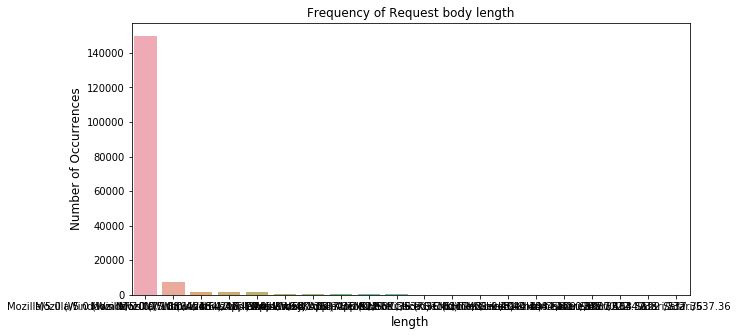

In [11]:
body_len  = bro_df['request_body_len'].value_counts()
body_len = body_len[:20,]
plt.figure(figsize=(10,5))
sns.barplot(body_len.index, body_len.values, alpha=0.8)
plt.title('Frequency of Request body length')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('length', fontsize=12)
plt.show()

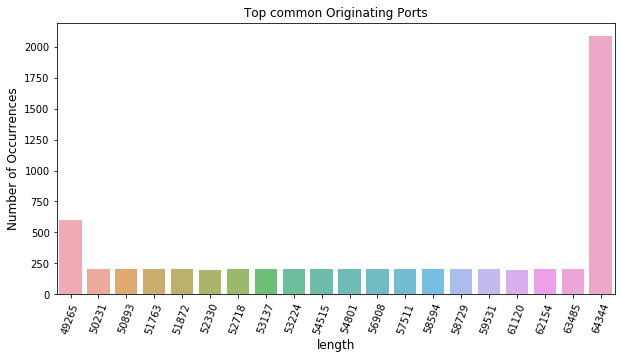

In [12]:
body_len  = bro_df['id.orig_p'].value_counts()
body_len = body_len[:20,]
plt.figure(figsize=(10,5))
sns.barplot(body_len.index, body_len.values, alpha=0.8)
plt.title('Top common Originating Ports')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('length', fontsize=12)
plt.xticks(rotation=70) 
plt.show()

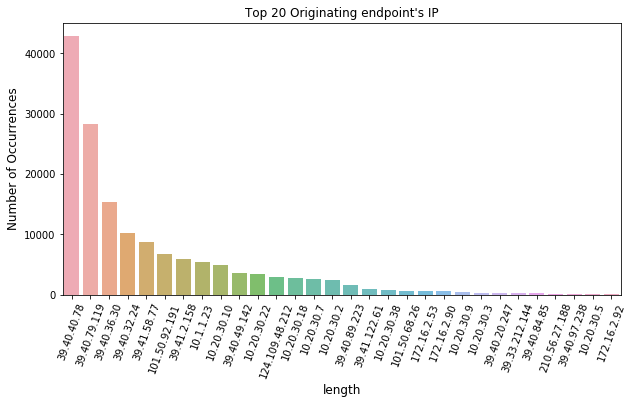

In [13]:
body_len  = bro_df['id.orig_h'].value_counts()
body_len = body_len[:30,]
plt.figure(figsize=(10,5))
sns.barplot(body_len.index, body_len.values, alpha=0.8)
plt.title("Top 20 Originating endpoint's IP")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('length', fontsize=12)
plt.xticks(rotation=70) 
plt.show()

In [14]:
def entropy(string):
    """Compute entropy on the string"""
    p, lns = Counter(string), float(len(string))
    return -sum(count/lns * math.log(count/lns, 2) for count in p.values())

def ip_embedding_ext(ip):
    tranformed = None
    try:
        tranformed = int(ipaddress.ip_address(ip))
        return tranformed
    except:
        return tranformed

In [15]:
bro_df['id.orig_h_e']=bro_df['id.orig_h'].apply(lambda x : ip_embedding_ext(x))

In [16]:
# File may have a tilde in it
if bro_log:
    bro_log = os.path.expanduser(bro_log)
    # Sanity check either http or dns log
    if 'http' in bro_log:
        log_type = 'http'
        features = ['id.orig_h_e','id.orig_p','id.resp_p', 'method', 'resp_mime_types', 'request_body_len']
    elif 'dns' in bro_log:
        log_type = 'dns'
        features = ['Z', 'proto', 'qtype_name', 'query_length', 'answer_length', 'entropy']
    else:
        print('This example only works with Zeek with http.log or dns.log files..')
        sys.exit(1)

    # Create a Pandas dataframe from a Zeek log
    try:
        log_to_df = log_to_dataframe.LogToDataFrame()
        #bro_df = pd.read_csv('http_Farrukh-Naveed-Anjum.csv')#log_to_df.create_dataframe(bro_log)
        #print(bro_df.head())
    except IOError:
        print('Could not open or parse the specified logfile: %s' % bro_log)
        sys.exit(1)
    print('Read in {:d} Rows...'.format(len(bro_df)))

    # Using Pandas we can easily and efficiently compute additional data metrics
    # Here we use the vectorized operations of Pandas/Numpy to compute query length
    # We'll also compute entropy of the query
    if log_type == 'dns':
        bro_df['query_length'] = bro_df['query'].str.len()
        bro_df['answer_length'] = bro_df['answers'].str.len()
        bro_df['entropy'] = bro_df['query'].map(lambda x: entropy(x))
    # Use the zat DataframeToMatrix class
    to_matrix = dataframe_to_matrix.DataFrameToMatrix()
    bro_matrix = to_matrix.fit_transform(bro_df[features])
    print(bro_matrix.shape)

Read in 167559 Rows...
Changing column id.resp_p to category...
Changing column method to category...
Changing column resp_mime_types to category...
Normalizing column id.orig_h_e...
(167559, 35)


In [17]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(behaviour='new',contamination=0.005,n_jobs=-1,verbose=3)  # Marking 20% as odd
odd_clf.fit(bro_matrix)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Building estimator 1 of 13 for this parallel run (total 100)...Building estimator 1 of 13 for this parallel run (total 100)...Building estimator 1 of 13 for this parallel run (total 100)...

Building estimator 1 of 13 for this parallel run (total 100)...
Building estimator 1 of 12 for this parallel run (total 100)...
Building estimator 1 of 12 for this parallel run (total 100)...Building estimator 1 of 12 for this parallel run (total 100)...

Building estimator 1 of 12 for this parallel run (total 100)...

Building estimator 2 of 13 for this parallel run (total 100)...
Building estimator 2 of 13 for this parallel run (total 100)...Building estimator 2 of 13 for this parallel run (total 100)...
Building estimator 2 of 12 for this parallel run (total 100)...

Building estimator 2 of 13 for this parallel run (total 100)...
Building estimator 2 of 12 for this parallel run (total 100)...Building estimator 2 of 12 for this parallel run (total 100)...

Building estimator 2 of 12 for this para

[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.7s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished


Building estimator 12 of 13 for this parallel run (total 100)...
Building estimator 13 of 13 for this parallel run (total 100)...
Building estimator 13 of 13 for this parallel run (total 100)...


IsolationForest(behaviour='new', bootstrap=False, contamination=0.005,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=None, verbose=3, warm_start=False)

In [19]:
http_pickle = {'model':odd_clf,'tranformer':to_matrix}

In [20]:
with open('iesco_http_ifroest_v4_june22.pkl', 'wb') as pickle_file:
    joblib.dump(http_pickle, pickle_file)

In [21]:
# odd_clf = joblib.load('Farukh.pkl')

In [22]:
# Now we create a new dataframe using the prediction from our classifier
predictions = odd_clf.predict(bro_matrix)

In [23]:
odd_df = bro_df[features][predictions == -1]
display_df = bro_df[predictions == -1]
display_df.drop_duplicates(subset=['id.orig_p','id.resp_p','method','resp_mime_types','request_body_len'],inplace=True)

C:\Users\atti-001\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# Now we're going to explore our odd observations with help from KMeans
odd_df.drop_duplicates(subset=['id.orig_p','id.resp_p','method','resp_mime_types','request_body_len'],inplace=True)
odd_matrix = to_matrix.fit_transform(odd_df)
num_clusters = min(len(odd_df), 4)  # 4 clusters unless we have less than 4 observations
display_df['cluster'] = KMeans(n_clusters=num_clusters).fit_predict(odd_matrix)
print(odd_matrix.shape)
# display(HTML(display_df.head(50).to_html()));

Changing column id.resp_p to category...
Changing column method to category...
Changing column resp_mime_types to category...
Changing column request_body_len to category...
Normalizing column id.orig_h_e...
(93, 9)


C:\Users\atti-001\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
# Now group the dataframe by cluster
if log_type == 'dns':
    features += ['query']

    
else:
    features += ['host']
    features += ['uri']
    features += ['id.orig_h']
    features +=['id.resp_h']


cluster_groups = display_df[list(display_df.columns)].groupby('cluster')

# Now print out the details for each cluster
print('<<< Outliers Detected! >>>')
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    group = group.T.drop_duplicates().T
    group.to_csv(str(key)+'_http.csv')

    display(HTML(group.to_html()))

<<< Outliers Detected! >>>

Cluster 0: 13 observations


,ts,id.orig_h,id.resp_h,id.orig_p,id.resp_p,method,resp_mime_types,request_body_len,host,uri,id.orig_h_e,cluster
456530,2020-04-04 16:43:39.265474080,172.16.2.53,172.217.18.142,65267,80,GET,text/html,0,redirector.gvt1.com,/edgedl/chromewebstore/L2Nocm9tZV9leHRlbnNpb24vYmxvYnMvZDM4QUFXaVZ5bThYeHlpdXd5bzU1RzRQUQ/8220.313.1.2_pkedcjkdefgpdelpbcmbmeomcjbeemfm.crx,2886730293,0
667973,2020-04-06 14:00:55.396415949,172.16.2.53,13.225.7.52,51913,80,GET,text/html,0,download2.veeam.com,/VeeamONE.Signature.1.3.16.0.package,2886730293,0
3510416,2020-02-03 19:21:53.706384897,172.16.2.210,216.58.210.78,53252,80,GET,text/html,0,redirector.gvt1.com,/edgedl/release2/Ia0qoRIeboJK8-PFagmmAQ_68/TXmoRvIZmJhUt0VubiBNZQ,2886730450,0
3911696,2020-01-29 19:21:44.912928104,172.16.2.210,172.217.18.142,50638,80,GET,text/html,0,redirector.gvt1.com,/edgedl/release2/QAGAylXf0UJzBTy06k5VCA_65/Fyr1skQf7c1JsECRI3B-Iw,2886730450,0
5093172,2020-03-05 06:57:41.313098907,172.16.2.53,172.217.18.142,59602,80,GET,text/html,0,redirector.gvt1.com,/edgedl/chromewebstore/L2Nocm9tZV9leHRlbnNpb24vYmxvYnMvMjk4QUFXWHV4aEtlX19peUJMaUFXd3dUZw/8019.1111.0.0_pkedcjkdefgpdelpbcmbmeomcjbeemfm.crx,2886730293,0
5102557,2020-03-05 10:55:41.496313095,172.16.2.53,216.58.210.78,49353,80,GET,text/html,0,redirector.gvt1.com,/edgedl/release2/AKHSPdroKIVYfJZJoEq_kfw_279/APX3V9Cwe3JSXFiCeaQE2yY,2886730293,0
6298734,2020-03-11 22:42:30.489281893,172.16.2.53,216.58.210.78,59716,80,GET,text/html,0,redirector.gvt1.com,/edgedl/release2/chrome_component/AJ-iM2e2OV3XrU2wYI4DQFs_5744/QkVE7D7DZpYDcYMQQaLdbw,2886730293,0
6298981,2020-03-11 22:44:16.145992994,172.16.2.53,216.58.210.78,59768,80,GET,text/html,0,redirector.gvt1.com,/edgedl/release2/AKY0LOrb5JUj96NmVPm9ZNE_357/AIuP9yMdJmMzGQ8j9BNIXRk,2886730293,0
6338410,2020-03-12 03:41:55.863837957,172.16.2.53,216.58.210.78,51377,80,GET,text/html,0,redirector.gvt1.com,/edgedl/release2/eg6_OTZqr56v8y7vUleFkA_359/ANBE2wkL2e5SjYoYcfBrz04,2886730293,0
6386827,2020-03-12 08:42:07.108212948,172.16.2.53,172.217.18.142,60029,80,GET,text/html,0,redirector.gvt1.com,/edgedl/release2/ALUR10wp08T6RnkZK8z97xQ_362/GNup5roIIe9mDL1ILucwWQ,2886730293,0



Cluster 1: 40 observations


,ts,id.orig_h,id.resp_h,id.orig_p,id.resp_p,method,resp_mime_types,request_body_len,host,uri,id.orig_h_e,cluster
4447939,2020-03-02 16:11:04.561897993,172.16.2.53,67.27.158.254,56657,80,GET,application/vnd.ms-cab-compressed,0,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/authrootstl.cab?720f00f3e2247090,2886730293,1
4743692,2020-03-03 21:16:28.522994995,172.16.2.211,67.26.137.254,55256,80,GET,application/vnd.ms-cab-compressed,0,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/authrootstl.cab?1765c835680a34dc,2886730451,1
4836787,2020-03-04 06:25:42.422588110,172.16.2.211,205.185.216.42,52399,80,GET,application/vnd.ms-cab-compressed,0,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/disallowedcertstl.cab?b29cc3c4131b0a87,2886730451,1
5100854,2020-03-05 10:52:07.685681105,172.16.2.53,110.93.229.210,49265,80,GET,application/vnd.ms-cab-compressed,0,download.windowsupdate.com,/d/msdownload/update/others/2018/01/26066719_4fc6c615b134f928be23d0443d9ddcdff2b1fdef.cab,2886730293,1
5101209,2020-03-05 10:52:36.065009117,172.16.2.53,8.252.5.126,49285,80,GET,application/vnd.ms-cab-compressed,0,ctldl.windowsupdate.com,/msdownload/update/v3/static/trustedr/en/authrootstl.cab?dc0588dcd313c54a,2886730293,1
5103164,2020-03-05 10:58:46.109277010,172.16.2.53,93.184.221.240,49613,80,GET,application/vnd.ms-cab-compressed,0,download.windowsupdate.com,/d/msdownload/update/software/crup/2013/09/windows8.1-kb2894179-x64-express_fbc3b8bf6a1c4e464652ffb1aa2e6b59e021f9e9.cab,2886730293,1
5103166,2020-03-05 10:58:46.140548944,172.16.2.53,93.184.221.240,49620,80,GET,application/vnd.ms-cab-compressed,0,download.windowsupdate.com,/d/msdownload/update/software/crup/2013/09/windows8.1-kb2894029-x64-express_72a480899b5b7825f9ef4c0bce6da60333b4159d.cab,2886730293,1
5103168,2020-03-05 10:58:46.328062057,172.16.2.53,93.184.221.240,49633,80,GET,application/vnd.ms-cab-compressed,0,download.windowsupdate.com,/d/msdownload/update/software/updt/2015/06/windows8.1-kb3054203-x64-express_16cb91a687d2c53730ef84ab3e6fa5f7bfb4e396.cab,2886730293,1
5103170,2020-03-05 10:58:46.265510081,172.16.2.53,93.184.221.240,49628,80,GET,application/vnd.ms-cab-compressed,0,download.windowsupdate.com,/d/msdownload/update/software/secu/2013/10/windows8.1-kb2862152-x64-express_c62425cec522041b88a5f402ff419927c38c149f.cab,2886730293,1
5103171,2020-03-05 10:58:46.343709946,172.16.2.53,93.184.221.240,49634,80,GET,application/vnd.ms-cab-compressed,0,download.windowsupdate.com,/d/msdownload/update/software/crup/2014/03/windows8.1-kb2939087-x64-express_eec1007faf15441bbbc4785903690b1b7abf8eff.cab,2886730293,1



Cluster 2: 23 observations


,ts,id.orig_h,id.resp_h,id.orig_p,id.resp_p,method,resp_mime_types,request_body_len,host,uri,id.orig_h_e,cluster
471910,2020-04-04 21:12:00.579416037,178.128.231.82,172.16.2.211,38678,8083,GET,text/html,0,210.2.172.19,/getpage.gch?pid=1001&logout=1,2994792274,2
737851,2020-04-07 04:17:13.758512020,203.135.57.138,172.16.2.211,57818,8083,GET,text/html,0,210.2.172.19,/UserManagement/DashBoard?ModuleID=Tg3R3dzL5d8qh2W0SyphdQ==,3414636938,2
846855,2020-04-07 12:49:00.676059008,178.128.231.82,172.16.2.211,38032,8083,GET,text/html,0,210.2.172.19,/getpage.gch?pid=1001&logout=1,2994792274,2
993065,2020-04-08 14:41:23.450541019,178.128.231.82,172.16.2.211,44428,8083,GET,text/html,0,210.2.172.19,/getpage.gch?pid=1001&logout=1,2994792274,2
1100873,2020-04-09 11:42:20.441277027,178.128.234.93,172.16.2.211,58084,8083,GET,text/html,0,210.2.172.19,/getpage.gch?pid=1001&logout=1,2994793053,2
3643588,2020-02-29 05:47:10.562048912,175.107.5.163,172.16.2.211,61281,8083,GET,text/html,0,210.2.172.19,/AttendanceManagement/Reports/Index,2943026595,2
4316801,2020-03-02 06:22:43.088829041,182.182.201.252,172.16.2.211,50127,8083,GET,text/html,0,210.2.172.19,/UserManagement/UserLogin/Logout,3065432572,2
4335219,2020-03-02 07:07:50.812335014,203.124.41.45,172.16.2.211,63001,8083,GET,text/html,0,210.2.172.19,/Content/logo/IESCOLogo.png,3413911853,2
4604594,2020-03-03 07:21:15.960200071,203.124.41.45,172.16.2.211,65143,8083,GET,text/html,0,210.2.172.19,/AttendanceManagement/Reports/Index,3413911853,2
4604748,2020-03-03 07:21:58.885870934,203.124.41.45,172.16.2.211,65160,8083,GET,text/html,0,210.2.172.19,/Content/logo/IESCOLogo.png,3413911853,2



Cluster 3: 17 observations


,ts,id.orig_h,id.resp_h,id.orig_p,id.resp_p,method,resp_mime_types,request_body_len,uri,id.orig_h_e,cluster
80739,2020-04-01 11:04:54.708975077,10.20.30.6,172.16.2.90,61713,5000,GET,text/html,0,/login,169090566,3
80750,2020-04-01 11:04:55.460062027,10.20.30.6,172.16.2.90,61717,5000,GET,text/html,0,/login,169090566,3
330960,2020-04-03 11:38:32.683149099,10.20.30.6,172.16.2.90,53679,5000,GET,text/html,0,/login,169090566,3
738083,2020-04-07 04:19:38.353301048,10.20.30.18,172.16.2.90,64206,5000,GET,text/html,0,/login,169090578,3
836907,2020-04-07 11:29:47.033051013,10.20.30.18,172.16.2.90,59671,5000,GET,text/html,0,/login,169090578,3
1058034,2020-04-09 05:20:54.996135950,10.20.30.10,172.16.2.90,58334,5000,GET,text/html,0,/login,169090570,3
1058052,2020-04-09 05:20:57.710143089,10.20.30.10,172.16.2.90,58333,5000,GET,text/html,0,/login,169090570,3
1074589,2020-04-09 07:57:15.127835035,10.20.30.2,172.16.2.90,55468,5000,GET,text/html,0,/app/kibana,169090562,3
1076214,2020-04-09 08:10:20.508611916,10.20.30.2,172.16.2.90,53777,5000,GET,text/html,0,/app/kibana,169090562,3
1091073,2020-04-09 10:17:48.106481075,10.20.30.2,172.16.2.90,61688,5000,GET,text/html,0,/app/kibana,169090562,3
